In [1]:
import os
import numpy as np
import pandas as pd
import cv2 as cv
from skimage.feature import hog
import tqdm
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

from skimage.io import imread
from skimage.transform import resize 

from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import RandomForestClassifier

sns.set()

# Creating datasets

In [2]:
def pre_process(image):
    # Pad image to obtain square image 
    w, h = image.shape
    max_dim = max(w, h)
    min_dim = min(w, h)
    direction = np.argmin([w, h])
    pad_ = [[0, 0], [0, 0]]
    pad_[direction] = [(max_dim - min_dim) //2, (max_dim - min_dim) //2]
    image = np.pad(image, pad_, mode='edge') 
    # Resize image 
    image = resize(image, (60, 80))
    # Gaussian Filtering
    blur = cv.GaussianBlur(image, (5,5), 0) 
    return blur

In [3]:
def create_dataset(root: str):
    labels = os.listdir(root)
    images = []
    
    df = {'file':[], 'label':[]}
    for label in tqdm.tqdm(labels):
        if ".json" not in label:
            for file in os.listdir(os.path.join(root, label)):
                try:
                    img = imread(os.path.join(root, label, file), as_gray=True)
                    # Pad, resize and blur raw image 
                    img = pre_process(img) 
                    images.append(img)
                    # Add label in dataframe, once for raw img
                    df['file'].append(os.path.join(root, label, file))
                    df['label'].append(label)
                except:
                    pass
    return pd.DataFrame(df), images

df, imgs = create_dataset(root="yoga_dataset/")

100%|██████████| 47/47 [04:01<00:00,  5.14s/it]


In [4]:
le = LabelEncoder()
df['cat_label'] = le.fit_transform(df['label'])

In [5]:
def compute_hog(imgs):
    hog_descriptors = []

    ppcr = 8
    ppcc = 8
    hog_images = []
    for image in tqdm.tqdm(imgs):
        # blur = pre_process(image)  # Uncomment if pre process have not been done during dataset loading 
        fd,hog_image = hog(image, orientations=8, pixels_per_cell=(ppcr,ppcc), cells_per_block=(2,2), block_norm= 'L2', visualize=True, feature_vector=True)
        hog_images.append(hog_image)
        hog_descriptors.append(fd)
    return hog_images, hog_descriptors

hog_images, hog_descriptors = compute_hog(imgs)

100%|██████████| 2758/2758 [00:59<00:00, 45.98it/s]


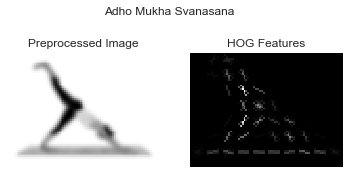

In [7]:
def visualize_img_hog(raw_img, hog_img, label):
    fig, ax = plt.subplots(1, 2, figsize=(6, 3))
    ax[0].imshow(raw_img, cmap='gray')
    ax[0].set_title(f'Preprocessed Image')

    ax[1].imshow(hog_img, cmap='gray')
    ax[1].set_title(f'HOG Features')

    for ax_ in ax:
        ax_.axis('off')

    if label:
        fig.suptitle(label)

    # fig.savefig('data_aug.png', bbox_inches='tight', pad_inches=0)
    plt.show()

img_nb = 2
visualize_img_hog(imgs[img_nb], hog_images[img_nb], label=df['label'].values[img_nb])

In [6]:
print(f'Nombre de classes distinctes: { len( df["cat_label"].unique() ) }')
print(f'Nombre de données totales: {len(df["cat_label"])}')

Nombre de classes distinctes: 47
Nombre de données totales: 2758


In [8]:
label2catlabel = {label: df[df.label == label]['cat_label'].unique()[0] for label in df['label'].unique()}
assert len(label2catlabel) == len(df.cat_label.unique())

# Data augmentation

In [9]:
# Can't do train test split on hog descriptors because we need to do data augmentation on training set only
# We need to do train_test_split on index of the dataset, then split indexes. We can then obtain the hog_descriptors of the test and validation set but the hog_descriptors of the training set need to be computed again. 

# 1. Split indexes between training and testing
# 2. Split indexes of training between training and validating

from sklearn.model_selection import StratifiedShuffleSplit

split_1 = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=42).split(df.index.values, y=df.cat_label.values)
(train_val_indices, test_indices) = next(split_1)

test_imgs, y_test = np.take(a=np.array(hog_descriptors), indices=test_indices, axis=0), np.take(a=np.array(df.cat_label.values), indices=test_indices)

y_train_val = np.take(a=np.array(df.cat_label.values), indices=train_val_indices)
assert train_val_indices[train_val_indices > len(train_val_indices)] != []  #Train val indices values must go from 0 to len(df.index.values)

split_2 = StratifiedShuffleSplit(n_splits=1, test_size=0.15, random_state=42).split(train_val_indices, y=y_train_val)
(train_indices, val_indices) = next(split_2)

y_train, y_val = np.take(y_train_val, train_indices), np.take(y_train_val, val_indices)
train_indices, val_indices = np.take(train_val_indices, train_indices), np.take(train_val_indices, val_indices)

assert train_indices[train_indices > len(train_val_indices)] != [] # train_indices should correspond to indices of df.cat_label.values and df.index.values
assert val_indices[val_indices > len(val_indices)] != []
assert val_indices[val_indices > len(train_val_indices)] != [] # val_indices should contain the indices of the df and hog_decriptors 1st input


# 3. Obtain testing set and validating set from already computed hog_descriptors
val_imgs = np.take(a=np.array(hog_descriptors), indices=val_indices, axis=0)

In [10]:
# 4. For all images corresponding to training set indexes, compute data_augmentation and construct hog_descriptors and labels 
# Perform Data Augmentation (only on train set!)

train_imgs = np.take(imgs, train_indices, axis=0)
train_imgs = list(train_imgs)
assert train_imgs[0].shape == (60, 80)
df_train = df.iloc[train_indices]
assert len(df_train['label'].unique()) == 47

from scipy.ndimage import rotate, zoom, shift

def data_augmentation(train_imgs, df_train, unsufficient_labels, vizualize=False):
    images_per_label = df_train.groupby(['label'])['label'].count()
    df_aug = {'file': [], 'label': [], 'cat_label':[]}
    aug_imgs = []
    # Compute data augmentation on imgs 
    for i, img in enumerate(tqdm.tqdm(train_imgs)):
        # Image augmentation
        aug_imgs += [resize(np.flip(img, axis=1), (60, 80))
                    ]

        file_name = df_train['file'].values[i]
        label = df_train['label'].values[i]
        file_names = [file_name.split('.png')[0] + '_flipped_' + '.png']
        if label in unsufficient_labels:
            aug_imgs += [
                    resize(rotate(img, angle=10, mode='nearest'), (60, 80)),
                    resize(rotate(img, angle=-10, mode='nearest'), (60, 80)),
                    resize(zoom(img, zoom=3), (60, 80)), 
                    resize(shift(img, (5, 10), mode='nearest'), (60, 80)),
                    resize(shift(img, (-5, -10), mode='nearest'), (60, 80))]
            file_names = [file_name.split('.png')[0] + '_flipped_' + '.png',
                        file_name.split('.png')[0] + '_pos_rot_' + '.png',
                        file_name.split('.png')[0] + '_neg_rot_' + '.png',
                        file_name.split('.png')[0] + '_zoomed_' + '.png',
                        file_name.split('.png')[0] + '_pos_shift_' + '.png',
                        file_name.split('.png')[0] + '_neg_shift_' + '.png']
        df_aug['file'] += file_names
        df_aug['label'] += [label]*len(file_names)
        df_aug['cat_label'] += [label2catlabel[label]]*len(file_names)

        if vizualize and (label in unsufficient_labels):
            for aug_img in aug_imgs:
                assert aug_img.shape == (60, 80)
                _, hog_image = hog(aug_img, orientations=8, pixels_per_cell=(8,8), cells_per_block=(2,2), block_norm= 'L2', visualize=True, feature_vector=True)
                visualize_img_hog(aug_img, hog_image, label)
            break

    df_train = pd.concat([df_train, pd.DataFrame(df_aug)])
    train_imgs += aug_imgs
    return train_imgs, df_train

# Identify label that need more than 1 time data augmentation 
images_per_label = df_train.groupby(['label'])['label'].count()
unsufficient_labels = images_per_label[images_per_label < 30 ].index
print(f'The classes : {unsufficient_labels} contain less than 30 images in the dataset, and must be more augmented')

train_imgs_aug, df_train_aug = data_augmentation(train_imgs, df_train, unsufficient_labels, vizualize=False) 

The classes : Index(['Alanasana', 'Ardha Navasana', 'Ashta Chandrasana', 'Navasana',
       'Parsva Virabhadrasana', 'Sivasana', 'Supta Kapotasana', 'Trikonasana',
       'Upavistha Konasana'],
      dtype='object', name='label') contain less than 30 images in the dataset, and must be more augmented
100%|██████████| 2109/2109 [00:05<00:00, 371.20it/s]


## Computing HOG features on augmented data

In [11]:
# 5. Compute hog_descriptors for training set and add them to train_imgs and y_train 
train_hog_imgs, train_hog_descriptors = compute_hog(train_imgs_aug)

train_imgs_aug, y_train_aug = np.array(train_hog_descriptors), np.array(df_train_aug.cat_label.values)

100%|██████████| 4788/4788 [01:48<00:00, 44.15it/s]


# Ensemble models

In [12]:
final_rf = RandomForestClassifier(n_estimators=4000, min_samples_leaf=1, max_depth=26)
final_svm = SVC(kernel='rbf', C=100, gamma=0.01, decision_function_shape="ovo", probability=True)

In [13]:
ens_model = VotingClassifier(estimators=[('rf', final_rf), ('svm', final_svm)], voting='soft')
ens_model.fit(np.concatenate((train_imgs_aug, val_imgs), axis=0), np.concatenate((y_train_aug, y_val), axis=0))

VotingClassifier(estimators=[('rf',
                              RandomForestClassifier(bootstrap=True,
                                                     class_weight=None,
                                                     criterion='gini',
                                                     max_depth=26,
                                                     max_features='auto',
                                                     max_leaf_nodes=None,
                                                     min_impurity_decrease=0.0,
                                                     min_impurity_split=None,
                                                     min_samples_leaf=1,
                                                     min_samples_split=2,
                                                     min_weight_fraction_leaf=0.0,
                                                     n_estimators=4000,
                                                     n_jobs=None,
           

In [14]:
final_pred = ens_model.predict(test_imgs)

In [15]:
print("Final accuracy", round(ens_model.score(test_imgs, y_test), 2))
print("Final F1 score", round(f1_score(y_test, final_pred, average="macro"), 2))

Final accuracy 0.7463768115942029
Final F1 score 0.6610873817509401


In [17]:
# Train the classifiers on training + validating dataset in order to get final 
for clf in (final_rf, final_svm):
    clf.fit(np.concatenate((train_imgs_aug, val_imgs), axis=0), np.concatenate((y_train_aug, y_val), axis=0))
    y_pred = clf.predict(test_imgs)
    print(clf.__class__.__name__, 'accuracy: ', round(accuracy_score(y_test, y_pred), 2))
    print(clf.__class__.__name__, 'f1-score: ', round(f1_score(y_test, y_pred, average="macro"), 2))

RandomForestClassifier accuracy:  0.7137681159420289
RandomForestClassifier f1-score:  0.610944545357957
SVC accuracy:  0.7318840579710145
SVC f1-score:  0.6531187670634003


# Final confusion matrix

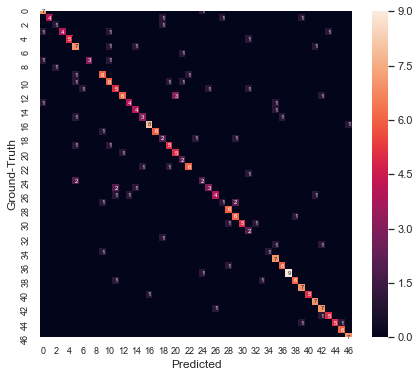

In [16]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
cm = confusion_matrix(y_test, final_pred)

plt.rcParams["axes.grid"] = False
fig, ax = plt.subplots(figsize=(7,6))

show_annot_array = cm >= 1
g = sns.heatmap(ax=ax, data=cm, annot=cm, annot_kws={'size': 6})

for text, show_annot in zip(ax.texts, (element for row in show_annot_array for element in row)):
    text.set_visible(show_annot)
    
g.set_xticklabels(g.get_xmajorticklabels(), fontsize = 9)
g.set_yticklabels(g.get_ymajorticklabels(), fontsize = 9)

plt.xlabel("Predicted")
plt.ylabel("Ground-Truth")
fig.savefig('final_cm.png', bbox_inches='tight', pad_inches=0, dpi=300)
plt.show()

# Feature importance

In [18]:
random_forest = RandomForestClassifier()
random_forest.fit(train_imgs_aug, y_train_aug)

# Get feature importance from RF classifier
importances = random_forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in random_forest.estimators_], axis=0)

forest_importances = pd.DataFrame(importances, index=range(0, len(importances)))
fd, hog_image = hog(imgs[0], orientations=8, pixels_per_cell=(8, 8), cells_per_block=(2,2),block_norm= 'L2',visualize=True)

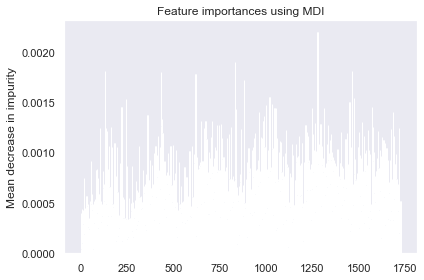

In [19]:
fig, ax = plt.subplots(1, 1)
plt.bar(x = forest_importances.index, height= np.squeeze(forest_importances.values)) # yerr=std)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

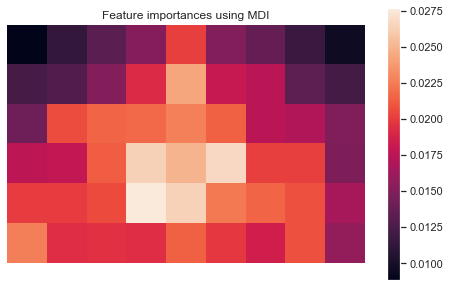

In [20]:
im_feature_importance = np.array(forest_importances.values).reshape(6, 9, 2, 2, 8)

fig, ax = plt.subplots(1, 1, figsize=(8, 5))
ax.axis('off')
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Image height")
ax.set_xlabel("Image width")

feature_map = ax.imshow(np.sum(im_feature_importance, axis=(2, 3, 4)))
fig.colorbar(feature_map, ax=ax)
fig.savefig('feature_importance.png', bbox_inches='tight', pad_inches=0)

# Grid search

## SVM

In [ ]:
from sklearn.model_selection import GridSearchCV
  
# defining parameter range
param_grid = {'C': [0.1, 1, 10, 100, 1000], 
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['rbf']} 
  
grid = GridSearchCV(SVC(), param_grid, refit = True, verbose = 3)
grid.fit(np.concatenate((train_imgs, val_imgs), axis=0), np.concatenate((y_train, y_val), axis=0))

In [26]:
print(grid.best_params_)

## Random Forest

In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = {'min_samples_leaf': [1,2], 
              'max_depth': range(20,30),
              'n_estimators': [400]} 
  
grid = GridSearchCV(RandomForestClassifier(), param_grid, refit = True, verbose = 3)
grid.fit(np.concatenate((train_imgs, val_imgs), axis=0), np.concatenate((y_train, y_val), axis=0))

In [ ]:
print(grid.best_params_)